# Step 01
# Preprocessing input images and annotations

In [1]:
%matplotlib inline

In [2]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np

import pathlib
from tqdm import tqdm

import skimage.io
import skimage.segmentation

import utils.dirtools
import utils.augmentation
from config import config_vars

# Configuration

In [3]:
config_vars

{'augment_images': False,
 'batch_size': 10,
 'boundary_boost_factor': 1,
 'boundary_labels_dir': '/data1/image-segmentation/dsb_eval/boundary_labels/',
 'boundary_size': 2,
 'cell_min_size': 16,
 'create_split_files': False,
 'crop_size': 256,
 'elastic_augmentations': 10,
 'elastic_distortion': 5,
 'elastic_points': 16,
 'epochs': 15,
 'learning_rate': 0.0001,
 'max_training_images': 0,
 'min_nucleus_size': 10,
 'normalized_images_dir': '/data1/image-segmentation/dsb_eval/norm_images/',
 'object_dilation': 3,
 'path_files_test': '/data1/image-segmentation/dsb_eval/test.txt',
 'path_files_training': '/data1/image-segmentation/dsb_eval/training.txt',
 'path_files_validation': '/data1/image-segmentation/dsb_eval/validation.txt',
 'pixel_depth': 8,
 'raw_annotations_dir': '/data1/image-segmentation/dsb_eval/raw_annotations/',
 'raw_images_dir': '/data1/image-segmentation/dsb_eval/raw_images/',
 'rescale_labels': True,
 'root_directory': '/data1/image-segmentation/dsb_eval/',
 'steps_per_

# Data partitions

In [4]:
# Prepare split files

if config_vars["create_split_files"]:
    file_list = os.listdir(config_vars["raw_images_dir"])

    [list_training, list_test, list_validation] = utils.dirtools.create_image_lists(
        config_vars["raw_images_dir"],
        config_vars["training_fraction"],
        config_vars["validation_fraction"]
    )

    utils.dirtools.write_path_files(config_vars["path_files_training"], list_training)
    utils.dirtools.write_path_files(config_vars["path_files_test"], list_test)
    utils.dirtools.write_path_files(config_vars["path_files_validation"], list_validation)
    
data_partitions = utils.dirtools.read_data_partitions(config_vars, load_augmented=False)

In [5]:
# Create output directories for transformed data

os.makedirs(config_vars["normalized_images_dir"], exist_ok=True)
os.makedirs(config_vars["boundary_labels_dir"], exist_ok=True)

# Image Preprocessing

In [6]:
# if config_vars["transform_images_to_PNG"]:
    
#     filelist = sorted(os.listdir(config_vars["raw_images_dir"]))

#     # run over all raw images
#     for filename in tqdm(filelist):

#         # load image and its annotation
#         orig_img = skimage.io.imread(config_vars["raw_images_dir"] + filename)       

#         # IMAGE

#         # normalize to [0,1]
#         percentile = 99.9
#         high = np.percentile(orig_img, percentile)
#         low = np.percentile(orig_img, 100-percentile)

#         img = np.minimum(high, orig_img)
#         img = np.maximum(low, img)

#         img = (img - low) / (high - low) # gives float64, thus cast to 8 bit later
#         img = skimage.img_as_ubyte(img) 

#         skimage.io.imsave(config_vars["normalized_images_dir"] + filename[:-3] + 'png', img)    
# else:
#     config_vars["normalized_images_dir"] = config_vars["raw_images_dir"]

In [7]:
# print(img.dtype, img.shape)
# filename = os.listdir(config_vars["normalized_images_dir"])
# img = skimage.io.imread(config_vars["normalized_images_dir"] + filename[-1])
# plt.figure(figsize=(10,10))
# plt.imshow(img)
# plt.show()
# plt.hist(img.flatten(), bins=100)
# plt.show()

# Create Output Targets: Three Class Boundary

In [8]:
filelist = sorted(os.listdir(config_vars["raw_annotations_dir"]))
total_objects = 0

# run over all raw images
for filename in tqdm(filelist):
    
    # GET ANNOTATION
    annot = skimage.io.imread(config_vars["raw_annotations_dir"] + filename)
    
    # strip the first channel
    if len(annot.shape) == 3:
        annot = annot[:,:,0]
    
    # label the annotations nicely to prepare for future filtering operation
    annot = skimage.morphology.label(annot)
    total_objects += len(np.unique(annot)) - 1
    
    # filter small objects, e.g. micronulcei
    annot = skimage.morphology.remove_small_objects(annot, min_size=config_vars["min_nucleus_size"])
    
    # find boundaries
    boundaries = skimage.segmentation.find_boundaries(annot)

    for k in range(2, config_vars["boundary_size"], 2):
        boundaries = skimage.morphology.binary_dilation(boundaries)
        
    # BINARY LABEL
    
    # prepare buffer for binary label
    label_binary = np.zeros((annot.shape + (3,)))
    
    # write binary label
    label_binary[(annot == 0) & (boundaries == 0), 0] = 1
    label_binary[(annot != 0) & (boundaries == 0), 1] = 1
    label_binary[boundaries == 1, 2] = 1
    
    # save it - converts image to range from 0 to 255
    skimage.io.imsave(config_vars["boundary_labels_dir"] + filename.replace(".tiff",".png"), label_binary)
    
print("Total objects: ",total_objects)

  0%|          | 0/735 [00:00<?, ?it/s]/home/jccaicedo/.local/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
  2%|▏         | 17/735 [00:00<00:13, 54.88it/s]/home/jccaicedo/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /data1/image-segmentation/dsb_eval/boundary_labels/07761fa39f60dc37022dbbe8d8694595fd5b77ceb2af2a2724768c8e524d6770.png is a low contrast image
  warn('%s is a low contrast image' % fname)
  4%|▎         | 27/735 [00:00<00:23, 29.77it/s]/home/jccaicedo/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /data1/image-segmentation/dsb_eval/boundary_labels/0b0d577159f0d6c266f360f7b8dfde46e16fa665138bf577ec3c6f9c70c0cd1e.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 10%|▉         | 73/735 [00:02<00:19, 34.41it/s]/home/jccaicedo/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: 

 85%|████████▍ | 623/735 [00:21<00:03, 29.64it/s]/home/jccaicedo/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /data1/image-segmentation/dsb_eval/boundary_labels/d8d4bf68a76e4e4c5f21de7ac613451f7115a04db686151e78b8ec0b6a22022b.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 88%|████████▊ | 645/735 [00:21<00:03, 29.88it/s]/home/jccaicedo/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /data1/image-segmentation/dsb_eval/boundary_labels/e1bcb583985325d0ef5f3ef52957d0371c96d4af767b13e48102bca9d5351a9b.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 90%|████████▉ | 658/735 [00:21<00:02, 30.15it/s]/home/jccaicedo/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /data1/image-segmentation/dsb_eval/boundary_labels/e5aeb5b3577abbebe8982b5dd7d22c4257250ad3000661a42f38bf9248d291fd.png is a low contrast image
  warn('%s is a low contrast image' % fname)
 92%|█████████▏| 677/735 

Total objects:  33617


int64 (360, 360)


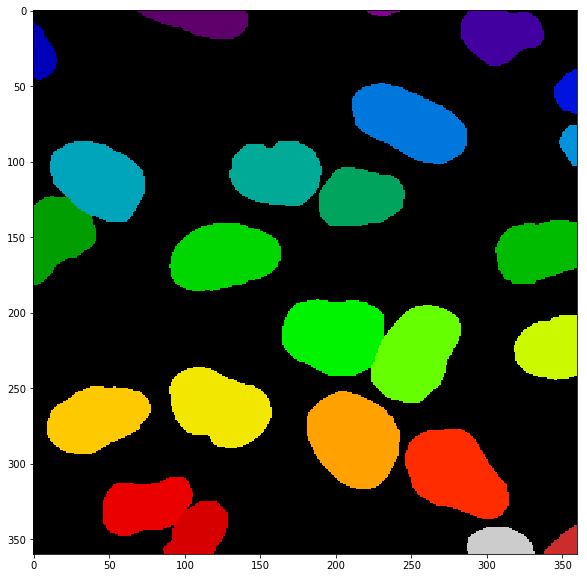

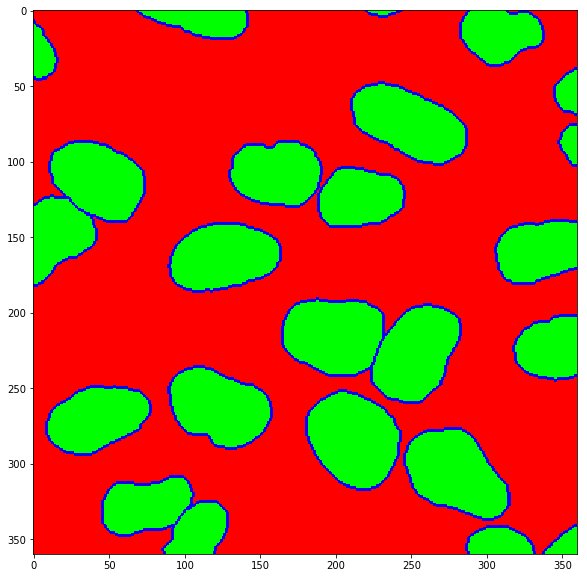

In [9]:
# Show example image 
print(annot.dtype, annot.shape)

# plot original annotation
plt.figure(figsize=(10,10))
plt.imshow(annot, cmap="nipy_spectral")
plt.show()

# plot boundary labels
plt.figure(figsize=(10,10))
plt.imshow(label_binary)
plt.show()


# Augment images (optional) 
* data augmentation using affine transformations 
* n_points x n_points data points are equally distributed in the image 
* distort 
* n_augmentations images are calculated for each image 


In [10]:
def generate_augmented_examples(filelist, n_augmentations, n_points, distort, dir_boundary_labels, dir_images_normalized_8bit):
    
    updated_filelist = []
    
    # run over all raw images
    for filename in tqdm(filelist):
        
        #if filename.startswith("IXMtest"):
        #    print("Skipping", filename)
        #    continue
            
        # check if boundary labels were calculated 
        my_file = pathlib.Path(dir_boundary_labels + filename)
        
        if my_file.is_file():
            
            # load image 
            x = skimage.io.imread(dir_images_normalized_8bit + filename)
            
            # load annotation 
            y = skimage.io.imread(dir_boundary_labels + filename)
            
            for n in range(1,n_augmentations):
                # augment image and annotation 
                x_augmented, y_augmented = utils.augmentation.deform(x, y, points = n_points, distort = distort)
                
                # filename for augmented images
                filename_augmented = os.path.splitext(filename)[0] + '_aug_{:03d}'.format(n) + os.path.splitext(filename)[1]
                skimage.io.imsave(dir_images_normalized_8bit + filename_augmented, x)
                skimage.io.imsave(dir_boundary_labels + filename_augmented, y)
                updated_filelist.append(filename_augmented)
                
    return filelist + updated_filelist 

if config_vars["augment_images"]:
    
    tmp_value = config_vars["max_training_images"]
    config_vars["max_training_images"] = 0
    tmp_partitions = utils.dirtools.read_data_partitions(config_vars, load_augmented=False)
    
    training_files = generate_augmented_examples(
        tmp_partitions["training"], 
        config_vars["elastic_augmentations"], 
        config_vars["elastic_points"], 
        config_vars["elastic_distortion"], 
        config_vars["boundary_labels_dir"], 
        config_vars["normalized_images_dir"]
    )
    
    config_vars["max_training_images"] = tmp_value
